In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [32]:
df=pd.read_csv('../data/005930.KS.csv')
df=df.set_index(pd.to_datetime(df.Date))
df=df[['Open','High','Low','Close','Volume','Adj Close']]
df

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2022-05-17,66600.0,67900.0,66600.0,67600.0,15680447,65934.203125
2022-05-18,68300.0,68700.0,67600.0,68100.0,16486319,66421.882813
2022-05-19,66500.0,67600.0,66500.0,67500.0,17073727,65836.671875
2022-05-20,67800.0,68400.0,67700.0,68000.0,12109671,66324.343750
2022-05-23,68800.0,68800.0,67600.0,67900.0,13684088,66226.820313
...,...,...,...,...,...,...
2023-05-11,64700.0,65100.0,64200.0,64200.0,11648905,64200.000000
2023-05-12,63700.0,64600.0,63600.0,64100.0,8693913,64100.000000
2023-05-15,64100.0,64600.0,63900.0,64500.0,8172021,64500.000000


In [33]:
df.isnull().sum() #null값 확인

Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [34]:
df.loc[df['Volume']==0]

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,


In [35]:
df['Volume']=df['Volume'].replace(0,np.nan)
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [36]:
df=df.dropna()
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [37]:
df

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2022-05-17,66600.0,67900.0,66600.0,67600.0,15680447,65934.203125
2022-05-18,68300.0,68700.0,67600.0,68100.0,16486319,66421.882813
2022-05-19,66500.0,67600.0,66500.0,67500.0,17073727,65836.671875
2022-05-20,67800.0,68400.0,67700.0,68000.0,12109671,66324.343750
2022-05-23,68800.0,68800.0,67600.0,67900.0,13684088,66226.820313
...,...,...,...,...,...,...
2023-05-11,64700.0,65100.0,64200.0,64200.0,11648905,64200.000000
2023-05-12,63700.0,64600.0,63600.0,64100.0,8693913,64100.000000
2023-05-15,64100.0,64600.0,63900.0,64500.0,8172021,64500.000000


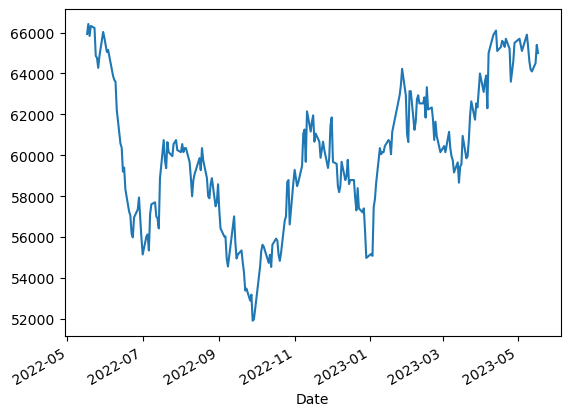

In [38]:
pig=df['Adj Close'].plot()

In [39]:
seq_length=7
batch_size=100

df=df[::-1]

train_size=int(df.shape[0]*0.8)
train_set=df[0:train_size]
test_set=df[train_size-seq_length:]
print(train_set.shape, test_set.shape)

(199, 6) (57, 6)


In [43]:
# 데이터 스케일링
# Input scale
scaler_x=MinMaxScaler()
scaler_x.fit(train_set.iloc[:,:-1])

train_set.iloc[:,:-1]= scaler_x.transform(train_set.iloc[:,:-1])
test_set.iloc[:,:-1]= scaler_x.transform(test_set.iloc[:,:-1])

#output scale
scaler_y=MinMaxScaler()
scaler_y.fit(train_set.iloc[:,[-1]])

train_set.iloc[:,-1]= scaler_y.transform(train_set.iloc[:,[-1]])
test_set.iloc[:,-1]= scaler_y.transform(test_set.iloc[:,[-1]])

C:\Users\admin\AppData\Local\Temp\ipykernel_9236\1877531814.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.iloc[:,:-1]= scaler_x.transform(train_set.iloc[:,:-1])
C:\Users\admin\AppData\Local\Temp\ipykernel_9236\1877531814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.iloc[:,:-1]= scaler_x.transform(test_set.iloc[:,:-1])
C:\Users\admin\AppData\Local\Temp\ipykernel_9236\1877531814.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the val

In [44]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [45]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(125)
if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

In [48]:
def build_dataset(time_series, seq_length):
    dataX=[]
    dataY=[]

    for i in range(0, len(time_series)-seq_length):
        _x=time_series[i:i+seq_length, :]
        _y=time_series[i+seq_length, [-1]]
        # print(_x, _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [49]:
trainX, trainY=build_dataset(np.array(train_set), seq_length)
testX, testY=build_dataset(np.array(test_set), seq_length)

In [50]:
trainX_tensor=torch.FloatTensor(trainX)
trainY_tensor=torch.FloatTensor(trainY)

testX_tensor=torch.FloatTensor(testX)
testY_tensor=torch.FloatTensor(testY)

train_dataset=TensorDataset(trainX_tensor, trainY_tensor)
train_dataload=DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset=TensorDataset(testX_tensor, testY_tensor)
test_dataload=DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [51]:
data_dim=6 #입력데이터 갯수
hidden_dim=10
output_dim=1
learning_rate=0.01
n_epochs=100


In [52]:
class Net(nn.Module):
    def __init__(self,input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim=hidden_dim
        self.seq_len=seq_len
        self.output_dim=output_dim
        self.layers=layers

        self.lstm=nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc=nn.Linear(hidden_dim, output_dim, bias=True)

    #학습 초기화를 위한 함수
    def reset_hidden_state(self):
        self.hidden=(
            torch.zeros(self.layers, self.seq_len, self.hidden_dim),
            torch.zeros(self.layers, self.seq_len, self.hidden_dim)
        )
    
    def forward(self, x):
        x, _status=self.lstm(x)
        x=self.fc(x[:,-1])
        return x

In [59]:
def train_model(model, train_df, num_epochs=None, lr=None, verbos=10, patience=10):
    criterion=nn.MSELoss().to(device)
    optimizer=optim.Adam(model.parameters(), lr=learning_rate)
    nb_epochs=num_epochs

    # epoch마다 loss저장
    train_hist=np.zeros(n_epochs)
    
    for epoch in range(nb_epochs):
        avg_cost=0
        total_batch=len(train_df)

        for batch_idx, samples in enumerate(train_df):
            x_train, y_train=samples

            model.reset_hidden_state()
            outputs=model(x_train)
            loss=criterion(outputs, y_train)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_cost+=loss/total_batch

        train_hist[epoch]=avg_cost

        if epoch % verbos==0:
            print('Epoch : ', '%04d' %(epoch), 'train loss', '{:.4f}'.format(avg_cost))
        if (epoch % patience == 0) & (epoch !=0):
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Earay Stopping')
                break
    return model.eval(), train_hist



Epoch :  0000 train loss 0.4967
Epoch :  0020 train loss 0.0293
Epoch :  0040 train loss 0.0188
Epoch :  0060 train loss 0.0065
Epoch :  0080 train loss 0.0035

 Earay Stopping


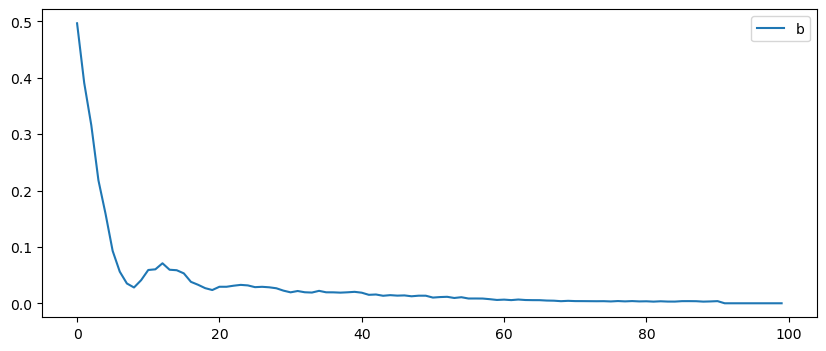

In [60]:
net=Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model, train_hist=train_model(net, train_dataload, num_epochs=n_epochs, lr=learning_rate, verbos=20, patience=10)

fig=plt.figure(figsize=(10,4))
plt.plot(train_hist, label='Training loss')
plt.legend('best')
plt.show()

In [61]:
PATH='../data/lstm_005930_KS.pth'
torch.save(model.state_dict(), PATH)

model=Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

Net(
  (lstm): LSTM(6, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [62]:
with torch.no_grad():
    pred=[]
    for pr in range(len(testX_tensor)):
        model.reset_hidden_state()

        predicted=model(torch.unsqueeze(testX_tensor[pr], 0))
        predicted=torch.flatten(predicted).item()
        pred.append(predicted)

    pred_inverse=scaler_y.inverse_transform(np.array(pred).reshape(-1,1))
    testY_inverse=scaler_y.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE:', MAE(pred_inverse,testY_inverse))

MAE SCORE: 8955.791912302902


In [70]:
# print(testY_inverse)
print(pred_inverse)

[[51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]
 [51453.89991989]]


Text(0.5, 1.0, 'Prediction result')

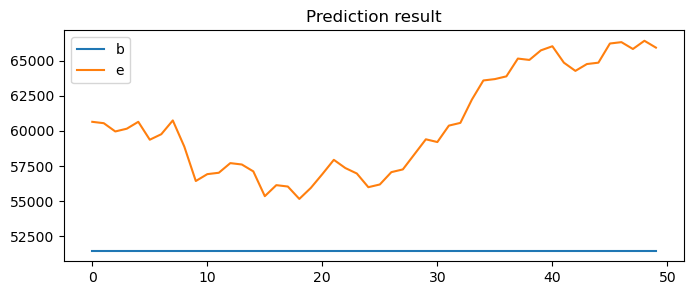

In [74]:
fig=plt.figure(figsize=(8,3))
# plt.plot(np.arange(len(pred_inverse)), pred_inverse, label='pred')
plt.plot(pred_inverse, label='pred')
# plt.plot(np.arange(len(testY_inverse)), testY_inverse, label='true')
plt.plot(testY_inverse, label='true')
plt.legend('best')
plt.title('Prediction result')
# plt.show()

In [75]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(GRU, self).__init__()
        self.num_classes=output_dim
        self.num_layers = layers
        self.input_size = input_dim
        self.hidden_size = hidden_dim
        self.seq_length = seq_len

        self.gru=nn.GRU(input_size=input_dim,hidden_size=hidden_dim,num_layers=layers,batch_first=True)
        self.fc_1=nn.Linear(hidden_dim,128)
        self.fc=nn.Linear(128, output_dim)
        self.relu=nn.ReLU()

    

       
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        output, (hn)= self.gru(x,(h_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out= self.relu(out)
        out= self.fc(out)
        return out

In [76]:
def train_model(model, train_df, num_epochs=None, lr=None, verbos=10, patience=10):
    criterion=nn.MSELoss().to(device)
    optimizer=optim.Adam(model.parameters(), lr=learning_rate)
    nb_epochs=num_epochs

    # epoch마다 loss저장
    train_hist=np.zeros(n_epochs)
    
    for epoch in range(nb_epochs):
        avg_cost=0
        total_batch=len(train_df)

        for batch_idx, samples in enumerate(train_df):
            x_train, y_train=samples

            # model.reset_hidden_state()
            outputs=model(x_train)
            loss=criterion(outputs, y_train)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_cost+=loss/total_batch

        train_hist[epoch]=avg_cost

        if epoch % verbos==0:
            print('Epoch : ', '%04d' %(epoch), 'train loss', '{:.4f}'.format(avg_cost))
        if (epoch % patience == 0) & (epoch !=0):
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Earay Stopping')
                break
    return model.eval(), train_hist



Epoch :  0000 train loss 0.1760
Epoch :  0020 train loss 0.0070
Epoch :  0040 train loss 0.0031

 Earay Stopping


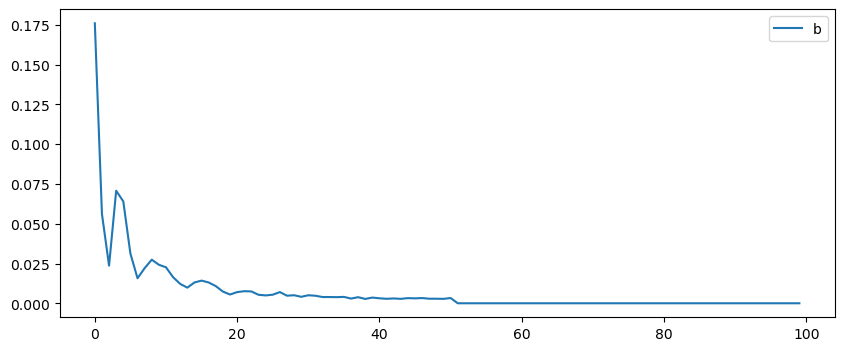

In [77]:
net=GRU(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model, train_hist=train_model(net, train_dataload, num_epochs=n_epochs, lr=learning_rate, verbos=20, patience=10)

fig=plt.figure(figsize=(10,4))
plt.plot(train_hist, label='Training loss')
plt.legend('best')
plt.show()

In [80]:
PATH_GRU='../data/GRU_stock1.pth'
torch.save(model.state_dict(), PATH_GRU)

model=GRU(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model.load_state_dict(torch.load(PATH_GRU), strict=False)
model.eval()

GRU(
  (gru): GRU(6, 10, batch_first=True)
  (fc_1): Linear(in_features=10, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

Text(0.5, 1.0, 'Prediction result')

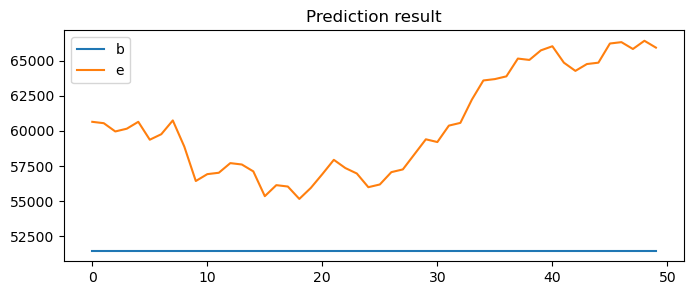

In [81]:
fig=plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label='pred')
# plt.plot(pred_inverse, label='pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label='true')
# plt.plot(testY_inverse, label='true')
plt.legend('best')
plt.title('Prediction result')
# plt.show()